## Design of a 3-stage class AB amplifier

![Circuit Schematic](class_ab_audio_amplifier_circuit.png)

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

pd.set_option('mode.copy_on_write', True)

# BASE_DIR = 'C:\\Users\\td\\Desktop\\uni\\cia\\lab\\github\\cia\\tables\\'
BASE_DIR = 'C:\\CIA\\cia_1_sara\\'

L_values = [60, 120, 180, 240, 500, 1000]
nmos_files = [f"{BASE_DIR}nmos_{L}n.csv" for L in L_values]
pmos_files = [f"{BASE_DIR}pmos_{L}n.csv" for L in L_values]

nmos_data = {}
pmos_data = {}

# load data
for L, nmos_file, pmos_file in zip(L_values, nmos_files, pmos_files):
    nmos_data[L] = pd.read_csv(nmos_file)
    pmos_data[L] = pd.read_csv(pmos_file)

for L in L_values:
    nmos_data[L] = np.abs(nmos_data[L])
    pmos_data[L] = np.abs(pmos_data[L])

scalable_columns_nmos = ['gm', 'id', 'gds', 'cdb', 'cgs', 'cgd', 'csb', 'cdd', 'w']
scalable_columns_pmos = ['gm', 'id', 'gds', 'cdb','cbd', 'csg', 'cgs', 'cgd', 'cdg','cbs', 'csb', 'cdd', 'w']

nmos_w_std = 5e-6
pmos_w_std = 5e-6

# add a column for the width of the transistor
for L in L_values:
    nmos_data[L]['w'] = nmos_w_std
    pmos_data[L]['w'] = pmos_w_std

# for L in L_values:
#     print('\n')
#     print(f'L = {L}n - NMOS')
#     print(nmos_data[L].to_string())
#     print('\n')
#     print(f'L = {L}n - PMOS')
#     print(pmos_data[L].to_string())
#     print('\n')

## Specifications

In [105]:
BW_spec = 20*10**3                      # Bandwidth
Gain_spec_dB = 54                       # Gain in dB
Gain_spec_lin = 10**(Gain_spec_dB/20)   # Gain in linear
GBW_spec =  Gain_spec_lin * BW_spec     # 10MHz

vout_swing = 0.4                        # Vout swing    
load = 16                               # Load resistance

Vdd = 1.2
Vcm = Vdd/2
Vss = 0

In [106]:
## Output Stage

In [107]:
id_A = 2.5 * 10**-3
id_B = vout_swing / load

# vdsat values to guarantee the saturation region
nmos_vdsat_min = 0
nmos_vdsat_max = 0.180
pmos_vdsat_min = 0
pmos_vdsat_max = 0.180

# max W values
nmos_w_max = 3.5 * 10**-3
pmos_w_max = 6.5 * 10**-3

# max Ka values based on the max W values
nmos_ka_max = nmos_w_max / nmos_w_std
pmos_ka_max = pmos_w_max / pmos_w_std

In [108]:
out_nmos = copy.deepcopy(nmos_data)
out_pmos = copy.deepcopy(pmos_data)

In [109]:
pmos_gmoverid_indices = {}

for L in L_values:
    out_nmos[L]['ka'] = id_A / out_nmos[L]['id']
    out_pmos[L]['ka'] = id_A / out_pmos[L]['id']

    out_nmos[L] = out_nmos[L].query(f' ka <= {nmos_ka_max}')
    out_pmos[L] = out_pmos[L].query(f' ka <= {pmos_ka_max}')

    for col in scalable_columns_nmos:
        out_nmos[L][col] = out_nmos[L][col] * out_nmos[L]['ka']
    for col in scalable_columns_pmos:
        out_pmos[L][col] = out_pmos[L][col] * out_pmos[L]['ka']
        
    # create a list of possible gmoverid values for PMOS sorted in descending order to fix the PMOS from the best value to the worst
    pmos_gmoverid_indices[L] = out_pmos[L]['gmoverid'].sort_values(ascending=False).index.tolist()

In [110]:
i_pmos_gmoverid = {}
pmos_fixed = {}

i_pmos_gmoverid[60]   = 0
i_pmos_gmoverid[120]  = 0
i_pmos_gmoverid[180]  = 0
i_pmos_gmoverid[240]  = 0
i_pmos_gmoverid[500]  = 0
i_pmos_gmoverid[1000] = 0

for L in L_values:
    index = pmos_gmoverid_indices[L][i_pmos_gmoverid[L]]
    pmos_fixed[L] = out_pmos[L].loc[index]

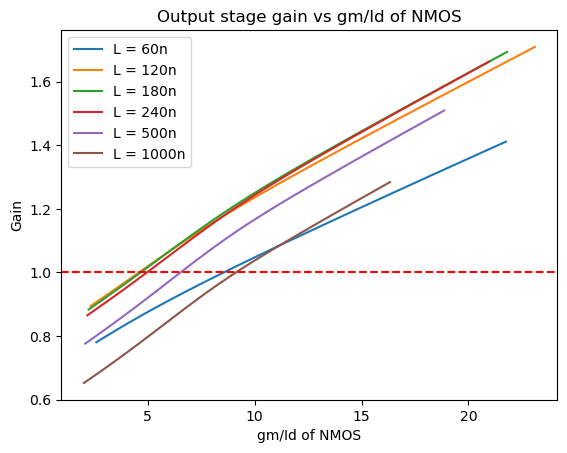

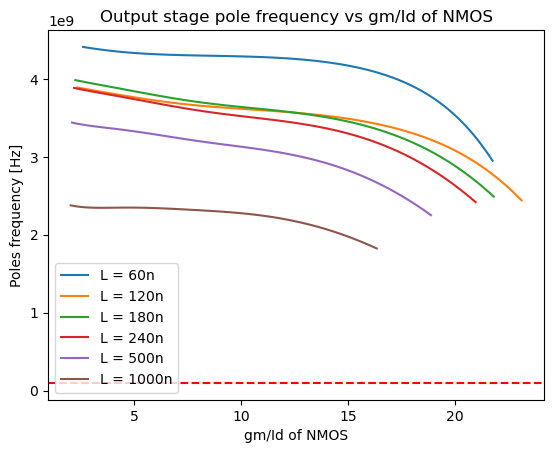

In [111]:
gain_A = {}
pole_A = {}

for L in L_values:
    gain_A[L] = (out_nmos[L]['gm'] + pmos_fixed[L]['gm']) / (out_nmos[L]['gds'] + pmos_fixed[L]['gds'] + 1/load)
    pole_A[L] = (pmos_fixed[L]['gds'] + out_nmos[L]['gds'] + 1/load) / (pmos_fixed[L]['cgd'] + pmos_fixed[L]['cdd'] + out_nmos[L]['cgd'] + out_nmos[L]['cdd'])

# plot the gains
for L in L_values:
    plt.plot(out_nmos[L]['gmoverid'], gain_A[L], label=f'L = {L}n')
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f'Output stage gain vs gm/Id of NMOS')
plt.xlabel('gm/Id of NMOS')
plt.ylabel('Gain')
plt.legend()
plt.show()

# plot the poles
for L in L_values:
    pole_A_Hz = pole_A[L] / (2 * np.pi)
    plt.plot(out_nmos[L]['gmoverid'], pole_A_Hz, label=f'L = {L}n')
plt.axhline(y=GBW_spec*10, color='r', linestyle='--')
plt.title(f'Output stage pole frequency vs gm/Id of NMOS')
plt.xlabel('gm/Id of NMOS')
plt.ylabel('Poles frequency [Hz]')   
plt.legend()
plt.show()

In [112]:
nmos_gmoverid = 30
nmos_fixed = {}

for L in L_values:
    nmos_nearest_index = (out_nmos[L]['gmoverid'] - nmos_gmoverid).abs().idxmin()
    nmos_fixed[L] = out_nmos[L].loc[nmos_nearest_index]

In [113]:
M_ND_A = {}
M_PD_A = {}
for L in L_values:
    M_ND_A[L] = nmos_fixed[L]
    M_PD_A[L] = pmos_fixed[L]
    
print(f'M_PD:  L = 120 nm  |  w = {M_PD_A[120]["w"]*10**6:>7.3f} um  |  id = {M_PD_A[120]["id"]:<6.2e} A  |  gds = {M_PD_A[120]["gds"]*10**6:>7.2f} uS  |  gm = {M_PD_A[120]["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_PD_A[120]["gmoverid"]:>7.2f}  |  vdsat = {M_PD_A[120]["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_PD_A[120]["vgs"]*10**3:>7.2f} mV   |  cdd = {M_PD_A[120]["cdd"]*10**15:>7.2f} fF  |  cgd = {M_PD_A[120]["cgd"]*10**15:>7.2f} fF  |  cgs = {M_PD_A[120]["cgs"]*10**15:>7.2f} fF  |  csb = {M_PD_A[120]["csb"]*10**15:>7.2f} fF')
print(f'M_ND:  L = 120 nm  |  w = {M_ND_A[120]["w"]*10**6:>7.3f} um  |  id = {M_ND_A[120]["id"]:<6.2e} A  |  gds = {M_ND_A[120]["gds"]*10**6:>7.2f} uS  |  gm = {M_ND_A[120]["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_ND_A[120]["gmoverid"]:>7.2f}  |  vdsat = {M_ND_A[120]["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_ND_A[120]["vgs"]*10**3:>7.2f} mV   |  cdd = {M_ND_A[120]["cdd"]*10**15:>7.2f} fF  |  cgd = {M_ND_A[120]["cgd"]*10**15:>7.2f} fF  |  cgs = {M_ND_A[120]["cgs"]*10**15:>7.2f} fF  |  csb = {M_ND_A[120]["csb"]*10**15:>7.2f} fF')


M_PD:  L = 120 nm  |  w = 6490.055 um  |  id = 2.50e-03 A  |  gds = 2738.28 uS  |  gm = 59253.92 uS  |  gmoverid =   23.70  |  vdsat =   54.72 mV  |  vgs =  425.00 mV   |  cdd = 1488.50 fF  |  cgd = 1465.84 fF  |  cgs = 3172.28 fF  |  csb =  255.83 fF
M_ND:  L = 120 nm  |  w = 3489.029 um  |  id = 2.50e-03 A  |  gds = 3233.04 uS  |  gm = 57758.36 uS  |  gmoverid =   23.10  |  vdsat =   60.89 mV  |  vgs =  400.00 mV   |  cdd =  766.01 fF  |  cgd =  743.14 fF  |  cgs = 1844.12 fF  |  csb =  156.11 fF


In [114]:
gain_A_final = {}
pole_A_final = {}

for L in L_values:
    gain_A_final[L] = (M_ND_A[L]['gm'] + M_PD_A[L]['gm']) / (M_ND_A[L]['gds'] + M_PD_A[L]['gds'] + 1/load)
    pole_A_final[L] = (M_PD_A[L]['gds'] + M_ND_A[L]['gds'] + 1/load) / (M_PD_A[L]['cgd'] + M_PD_A[L]['cdd'] + M_ND_A[L]['cgd'] + M_ND_A[L]['cdd'])

### max current analysis (25mA)

In [115]:
# reset the tables
out_nmos = copy.deepcopy(nmos_data)
out_pmos = copy.deepcopy(pmos_data)

In [116]:
# scale the tables with the Ka from the fixed transistors
for L in L_values:
    for col in scalable_columns_nmos:
        out_nmos[L][col] = out_nmos[L][col] * nmos_fixed[L]['ka']
    for col in scalable_columns_pmos:
        out_pmos[L][col] = out_pmos[L][col] * pmos_fixed[L]['ka']

# # print the scaled tables
# for L in L_values:
#     print('\n')
#     print(f'L = {L}n - NMOS')
#     print(out_nmos[L].to_string())
#     print('\n')
#     print(f'L = {L}n - PMOS')
#     print(out_pmos[L].to_string())
#     print('\n')


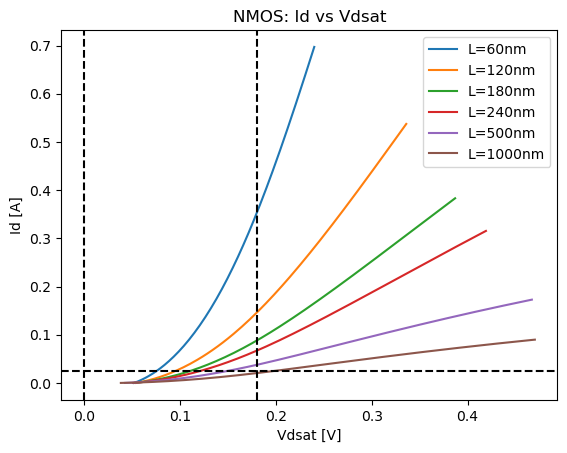

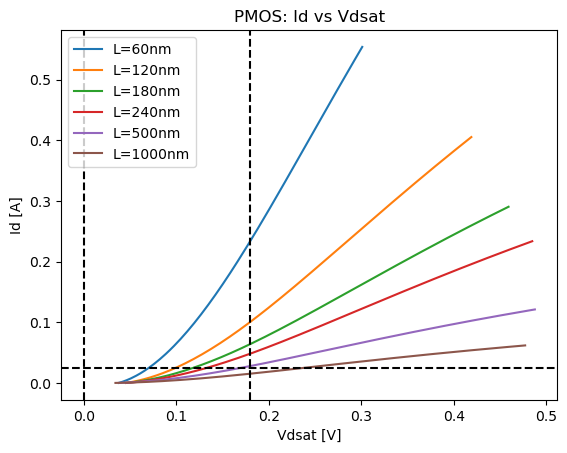

In [117]:
# Plot Id vs Vdsat for NMOS
for L in L_values:
    plt.plot(out_nmos[L]['vdsat'], out_nmos[L]['id'], label=f'L={L}nm')
plt.axhline(y=id_B, color='k', linestyle='--')
plt.axvline(x=nmos_vdsat_min, color='k', linestyle='--')
plt.axvline(x=nmos_vdsat_max, color='k', linestyle='--')
plt.xlabel('Vdsat [V]')
plt.ylabel('Id [A]')
plt.title('NMOS: Id vs Vdsat')
plt.legend()
plt.show()

# Plot Id vs Vdsat for PMOS
for L in L_values:
    plt.plot(out_pmos[L]['vdsat'], out_pmos[L]['id'], label=f'L={L}nm')
plt.axhline(y=id_B, color='k', linestyle='--')
plt.axvline(x=pmos_vdsat_min, color='k', linestyle='--')
plt.axvline(x=pmos_vdsat_max, color='k', linestyle='--')
plt.xlabel('Vdsat [V]')
plt.ylabel('Id [A]')
plt.title('PMOS: Id vs Vdsat')
plt.legend()
plt.show()

In [118]:
nmos_final = {}
pmos_final = {}

for L in L_values:
    # filter the results to show only the values that meet the requirements
    out_nmos[L] = out_nmos[L].query(f'vdsat >= {nmos_vdsat_min} and vdsat <= {nmos_vdsat_max} and w <= {nmos_w_max}')
    out_pmos[L] = out_pmos[L].query(f'vdsat >= {pmos_vdsat_min} and vdsat <= {pmos_vdsat_max} and w <= {pmos_w_max}')

    # get the nearest value to the target Id
    nmos_nearest_index = (out_nmos[L]['id'] - id_B).abs().idxmin()
    pmos_nearest_index = (out_pmos[L]['id'] - id_B).abs().idxmin()

    nmos_final[L] = out_nmos[L].loc[nmos_nearest_index]
    pmos_final[L] = out_pmos[L].loc[pmos_nearest_index]

In [119]:
gain_B_NMOS_final = {}
gain_B_PMOS_final = {}
pole_B_NMOS_final = {}
pole_B_PMOS_final = {}

for L in L_values:
    gain_B_NMOS_final[L] = nmos_final[L]['gm'] / (nmos_final[L]['gds'] + 1/load)
    gain_B_PMOS_final[L] = pmos_final[L]['gm'] / (pmos_final[L]['gds'] + 1/load)
    pole_B_NMOS_final[L] = (nmos_final[L]['gds'] + 1/load) / (nmos_final[L]['cgd'] + nmos_final[L]['cdd'] + pmos_final[L]['cgd'] + pmos_final[L]['cdd'])
    pole_B_PMOS_final[L] = (pmos_final[L]['gds'] + 1/load) / (pmos_final[L]['cgd'] + pmos_final[L]['cdd'] + nmos_final[L]['cgd'] + nmos_final[L]['cdd'])

In [120]:
M_ND_B = {}
M_PD_B = {}
for L in L_values:
    M_ND_B[L] = nmos_final[L]
    M_PD_B[L] = pmos_final[L]

In [121]:
M_ND_PD_L = 120
M_ND_L = M_ND_PD_L
M_PD_L = M_ND_PD_L

# verify gain and poles for each case A and B for the chosen L values for each transistor
print(f'Gain and poles for case A (Id = iq = {id_A} A)')
print(f'    Gain: {20*np.log10(gain_A_final[M_ND_L])} dB')
print(f'    Pole: {pole_A_final[M_ND_L] * 10**-6 * 1/(2*np.pi)} MHz')
print()
print(f'Gain and poles for case B (Id = id target = {id_B} A)')
print('NMOS:')
print(f'    Gain: {20*np.log10(gain_B_NMOS_final[M_ND_L])} dB')
print(f'    Pole: {pole_B_NMOS_final[M_ND_L] * 10**-6 * 1/(2*np.pi)} MHz')
print('PMOS:')
print(f'    Gain: {20*np.log10(gain_B_PMOS_final[M_PD_L])} dB')
print(f'    Pole: {pole_B_PMOS_final[M_PD_L] * 10**-6 * 1/(2*np.pi)} MHz')

Gain and poles for case A (Id = iq = 0.0025 A)
    Gain: 4.65445479777805 dB
    Pole: 2441.48815280792 MHz

Gain and poles for case B (Id = id target = 0.025 A)
NMOS:
    Gain: 12.217610433825053 dB
    Pole: 3166.638339443506 MHz
PMOS:
    Gain: 12.29298828517263 dB
    Pole: 3157.0645807939404 MHz


### Expected operating points

In [122]:
# print('Final sizing for bias circuit:')
# print(f'M_0:  L = {BIAS_M_0_L:>4} nm  |  w = {BIAS_M_0["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_0["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_0["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_0["id"]:<6.2e} A  |  vgs = {BIAS_M_0["vgs"]*10**3:>7.2f} mV')
# print(f'M_1:  L = {BIAS_M_1_L:>4} nm  |  w = {BIAS_M_1["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_1["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_1["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_1["id"]:<6.2e} A  |  vgs = {BIAS_M_1["vgs"]*10**3:>7.2f} mV')
# print(f'M_3:  L = {BIAS_M_3_L:>4} nm  |  w = {BIAS_M_3["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_3["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_3["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_3["id"]:<6.2e} A  |  vgs = {BIAS_M_3["vgs"]*10**3:>7.2f} mV')
# print(f'M_2:  L = {BIAS_M_2_L:>4} nm  |  w = {BIAS_M_2["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_2["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_2["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_2["id"]:<6.2e} A  |  vgs = {BIAS_M_2["vgs"]*10**3:>7.2f} mV')
# print(f'M_4:  L = {BIAS_M_4_L:>4} nm  |  w = {BIAS_M_4["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_4["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_4["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_4["id"]:<6.2e} A  |  vgs = {BIAS_M_4["vgs"]*10**3:>7.2f} mV')
# print(f'M_5:  L = {BIAS_M_5_L:>4} nm  |  w = {BIAS_M_5["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_5["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_5["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_5["id"]:<6.2e} A  |  vgs = {BIAS_M_5["vgs"]*10**3:>7.2f} mV')
# print(f'M_6:  L = {BIAS_M_6_L:>4} nm  |  w = {BIAS_M_6["w"]*10**6:>7.3f} um  |  vdsat = {BIAS_M_6["vdsat"]*10**3:>7.2f} mV  |  vth = {BIAS_M_6["vth"]*10**3:>7.2f} mV  |  id = {BIAS_M_6["id"]:<6.2e} A  |  vgs = {BIAS_M_6["vgs"]*10**3:>7.2f} mV')


### Final sizing output stage

In [123]:
M_ND = M_ND_B[M_ND_L]
M_PD = M_PD_B[M_PD_L]

print(f'M_PD:  L = {M_PD_L:>4} nm  |  w = {M_PD["w"]*10**6:>7.3f} um  |  id = {M_PD["id"]:<6.2e} A  |  gds = {M_PD["gds"]*10**6:>7.2f} uS  |  gm = {M_PD["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_PD["gmoverid"]:>7.2f}  |  vdsat = {M_PD["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_PD["vgs"]*10**3:>7.2f} mV   |  cdd = {M_PD["cdd"]*10**15:>7.2f} fF  |  cgd = {M_PD["cgd"]*10**15:>7.2f} fF  |  cgs = {M_PD["cgs"]*10**15:>7.2f} fF  |  csb = {M_PD["csb"]*10**15:>7.2f} fF')
print(f'M_ND:  L = {M_ND_L:>4} nm  |  w = {M_ND["w"]*10**6:>7.3f} um  |  id = {M_ND["id"]:<6.2e} A  |  gds = {M_ND["gds"]*10**6:>7.2f} uS  |  gm = {M_ND["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_ND["gmoverid"]:>7.2f}  |  vdsat = {M_ND["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_ND["vgs"]*10**3:>7.2f} mV   |  cdd = {M_ND["cdd"]*10**15:>7.2f} fF  |  cgd = {M_ND["cgd"]*10**15:>7.2f} fF  |  cgs = {M_ND["cgs"]*10**15:>7.2f} fF  |  csb = {M_ND["csb"]*10**15:>7.2f} fF')


M_PD:  L =  120 nm  |  w = 6490.055 um  |  id = 2.42e-02 A  |  gds = 27457.31 uS  |  gm = 370412.69 uS  |  gmoverid =   15.33  |  vdsat =   98.18 mV  |  vgs =  540.00 mV   |  cdd = 1533.86 fF  |  cgd = 1458.11 fF  |  cgs = 5791.97 fF  |  csb =  588.91 fF
M_ND:  L =  120 nm  |  w = 3489.029 um  |  id = 2.43e-02 A  |  gds = 27730.10 uS  |  gm = 368325.65 uS  |  gmoverid =   15.15  |  vdsat =   94.88 mV  |  vgs =  520.00 mV   |  cdd =  804.91 fF  |  cgd =  738.08 fF  |  cgs = 3126.91 fF  |  csb =  307.54 fF


## Cascode Stage

In [124]:
# start from new tables
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

# for L in L_values:
#     print('\n')
#     print(f'L = {L}n - NMOS')
#     print(nmos[L].to_string())
#     print('\n')
#     print(f'L = {L}n - PMOS')
#     print(pmos[L].to_string())

### M3

In [125]:
security_factor_1 = 10  # gm1/gds1 = 25
security_factor_2 = 1.2 # gds2 = 20% of gds1
security_factor_3 = 1.2 # gds4 * (gds5/gm5) = 20% (gds1 + gds2)*(gds3/gm3)

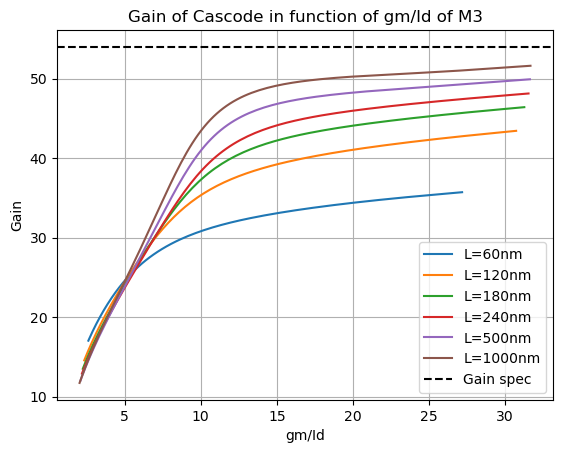

In [126]:
G_ap = {}
# plot gain of cascode in function of gm/Id
plt.figure()
for L in L_values:
    G_ap[L] = security_factor_1 * (1 / ( security_factor_2 * (nmos[L]['gds'] / nmos[L]['gm']) * security_factor_3))
    G_ap_dB = 20*np.log10(G_ap[L])
    plt.plot(nmos[L]['gmoverid'], G_ap_dB, label=f'L={L}nm')
plt.axhline(y=Gain_spec_dB, color='k', linestyle='--', label='Gain spec')
plt.xlabel('gm/Id')
plt.ylabel('Gain')
plt.legend()
plt.title('Gain of Cascode in function of gm/Id of M3')
plt.grid()
plt.show()

In [127]:
M_3_L = 240
M_3_gmoverid_desired = 25
M_3_index = (np.abs(nmos[M_3_L]['gmoverid'] - M_3_gmoverid_desired)).idxmin()
M_3 = nmos[M_3_L].iloc[M_3_index]

In [128]:
G_prev_dB = 20*np.log10(G_ap[M_3_L][M_3_index])

### M1

In [129]:
M_1_L = 1000
M_1_gmoverid_desired = 25
M_1_index = (np.abs((pmos[M_1_L]['gmoverid']) - M_1_gmoverid_desired)).idxmin()
M_1 = pmos[M_1_L].iloc[M_1_index]

### M4

In [130]:
M_4_L = 1000
M_4_gmoverid_desired = 10
M_4_index = (np.abs(pmos[M_4_L]['gmoverid'] - M_4_gmoverid_desired)).idxmin()
M_4 = pmos[M_4_L].iloc[M_4_index]

### M5

In [131]:
M_5_L = 240
M_5_gmoverid_desired = 25
M_5_index = (np.abs(pmos[M_5_L]['gmoverid'] - M_5_gmoverid_desired)).idxmin()
M_5 = pmos[M_5_L].iloc[M_5_index]

### M2

In [132]:
M_2_L = 1000
M_2_gmoverid_desired = 10
M_2_index = (np.abs(nmos[M_2_L]['gmoverid'] - M_2_gmoverid_desired)).idxmin()
M_2 = nmos[M_2_L].iloc[M_2_index]

### M0

In [133]:
M_0_L = 1000
M_0_gmoverid_desired = 10
M_0_index = (np.abs(pmos[M_0_L]['gmoverid'] - M_0_gmoverid_desired)).idxmin()
M_0 = pmos[M_0_L].iloc[M_0_index]

### Scale all the transistors

#### scale M1, M4 and M5 to have the same current as M3

In [134]:
ka_M1 = M_3['id'] / M_1['id']
ka_M4 = M_3['id'] / M_4['id']
ka_M5 = M_3['id'] / M_5['id']

M_1['ka'] = ka_M1
M_4['ka'] = ka_M4
M_5['ka'] = ka_M5

for col in scalable_columns_pmos:
    M_1[col] = M_1[col] * ka_M1
    M_4[col] = M_4[col] * ka_M4
    M_5[col] = M_5[col] * ka_M5

### reset the tables just in case

In [135]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

#### scale M0 and M2 to have 2 * Id M3

In [136]:
ka_M0 = (2*M_1['id']) / M_0['id']
ka_M2 = (M_1['id'] + M_3['id']) / M_2['id']

M_0['ka'] = ka_M0
M_2['ka'] = ka_M2

for col in scalable_columns_pmos:
    M_0[col] = M_0[col] * ka_M0

for col in scalable_columns_nmos:
    M_2[col] = M_2[col] * ka_M2

### Evaluate poles

In [137]:
# Calculate P4
P4 = (M_4['gm'] / (2 * M_4['cgs'])) / (10**6) * 1 / (2 * np.pi)
print(f"P4 = {P4:.3f} MHz")

# Calculate P4_real
P4_real = M_4['gm'] / (2 *(M_4['cgs'] + M_4['cgd']) + M_5['cgd'] + M_5['cdd'] + M_3['cgd'] + M_3['cdd']) / (10**6) * 1 / (2 * np.pi)
print(f"P4_real = {P4_real:.3f} MHz")

# Calculate P3
P3 = (M_5['gm'] / (M_5['cgs'] + M_5['csb'] + M_4['cdd'])) / (10**6) * 1 / (2 * np.pi)
print(f"P3 = {P3:.3f} MHz")

# Calculate P3_real
P3_real = ((M_5['gm'] + M_4['gds']) / (M_5['cgs'] + M_5['csb'] + M_4['cdd'] + M_4['cdg'])) / (10**6) * 1 / (2 * np.pi)
print(f"P3_real = {P3_real:.3f} MHz")

# Calculate P2
P2 = (M_3['gm'] / (M_3['cgs'] + M_3['csb'] + M_2['cdd'] + M_1['cdd'])) / (10**6) * 1 / (2 * np.pi)
print(f"P2 = {P2:.3f} MHz")

# Calculate P2_real
P2_real = ((M_3['gm'] + M_1['gds'] + M_2['gds']) / (M_3['cgs'] + M_3['csb'] + M_2['cdd'] + M_2['cgd'] + M_1['cdd'] + M_1['cdg'])) / (10**6) * 1 / (2 * np.pi)
print(f"P2_real = {P2_real:.3f} MHz")

P4 = 134.126 MHz
P4_real = 95.282 MHz
P3 = 876.842 MHz
P3_real = 846.724 MHz
P2 = 464.384 MHz
P2_real = 326.376 MHz


In [138]:
# # print all transistors
# print('\n')
# print(f'M_0')
# print(M_0.to_string())
# print('\n')
# print(f'M_1')
# print(M_1.to_string())
# print('\n')
# print(f'M_2')
# print(M_2.to_string())
# print('\n')
# print(f'M_3')
# print(M_3.to_string())
# print('\n')
# print(f'M_4')
# print(M_4.to_string())
# print('\n')
# print(f'M_5')
# print(M_5.to_string())
# print('\n')

In [139]:
G_real = (M_1['gm']) / ((M_1['gds'] + M_2['gds']) * (M_3['gds'] / M_3['gm']) + (M_4['gds'] * (M_5['gds']/ M_5['gm'])))
G_real_dB = 20*np.log10(G_real)

print(f'Prev Gain = {G_prev_dB:.2f} dB')
print(f'Real Gain = {G_real_dB:.2f} dB')
# print both the approximated and real security factors
print(f'Overall approximation validity: {G_real_dB / G_prev_dB:.2f}')

Prev Gain = 47.07 dB
Real Gain = 50.04 dB
Overall approximation validity: 1.06


In [140]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

In [141]:
C_13 = 1 * 10**-12
security_margin_GBW = 1.4 # 20% margin over the spec

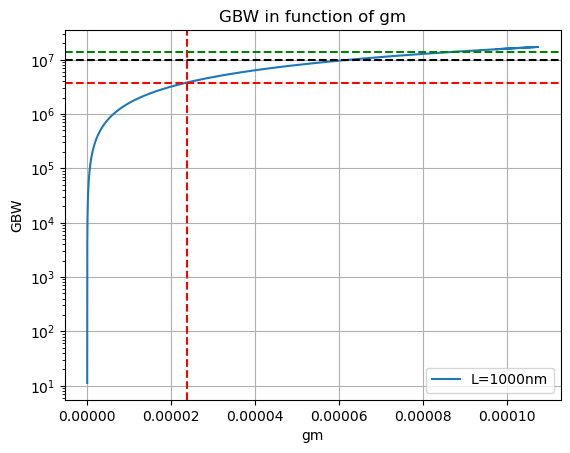

In [142]:
# GBW = gm1/C_13

GBW = (pmos[M_1_L]['gm'] / C_13) * 1/(2*np.pi)
GBW_M1 = (M_1['gm'] / C_13) * 1/(2*np.pi)

plt.figure()
plt.plot(pmos[M_1_L]['gm'], GBW, label=f'L={L}nm')
plt.axvline(x=M_1['gm'], color='r', linestyle='--')
plt.axhline(y=GBW_M1, color='r', linestyle='--')
plt.axhline(y=GBW_spec, color='k', linestyle='--')
plt.axhline(y=security_margin_GBW*GBW_spec, color='g', linestyle='--')
plt.yscale('log')
plt.xlabel('gm')
plt.ylabel('GBW')
plt.legend()
plt.title('GBW in function of gm')
plt.grid()
plt.show()

In [143]:
M_1_gm_desired = (GBW_spec * security_margin_GBW) * C_13 * 2 * np.pi
print(f'M1_gm_desired = {M_1_gm_desired:.2e}')

ka_1st_stage = M_1_gm_desired / M_1['gm']

# scale NMOS transistors (M2 and M3)
for col in scalable_columns_nmos:
    M_2[col] = M_2[col] * ka_1st_stage
    M_3[col] = M_3[col] * ka_1st_stage

# scale PMOS transistors (M1, M4 and M5 and M0)
for col in scalable_columns_pmos:
    M_1[col] = M_1[col] * ka_1st_stage
    M_4[col] = M_4[col] * ka_1st_stage
    M_5[col] = M_5[col] * ka_1st_stage
    M_0[col] = M_0[col] * ka_1st_stage

M1_gm_desired = 8.82e-05


### Final sizing

In [144]:
print(f'Final sizing for cascode stage after adjust of {ka_1st_stage}:')
print(f'M0:  L = {M_0_L:>4} nm  |  w = {M_0["w"]*10**6:>7.3f} um  |  id = {M_0["id"]:<6.2e} A  |  gds = {M_0["gds"]*10**6:>7.2f} uS  |  gm = {M_0["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_0["gmoverid"]:>7.2f}  |  vdsat = {M_0["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_0["vgs"]*10**3:>7.2f} mV   |  cdd = {M_0["cdd"]*10**15:>7.2f} fF  |  cgd = {M_0["cgd"]*10**15:>7.2f} fF  |  cgs = {M_0["cgs"]*10**15:>7.2f} fF  |  csb = {M_0["csb"]*10**15:>7.2f} fF')
print(f'M1:  L = {M_1_L:>4} nm  |  w = {M_1["w"]*10**6:>7.3f} um  |  id = {M_1["id"]:<6.2e} A  |  gds = {M_1["gds"]*10**6:>7.2f} uS  |  gm = {M_1["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_1["gmoverid"]:>7.2f}  |  vdsat = {M_1["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_1["vgs"]*10**3:>7.2f} mV   |  cdd = {M_1["cdd"]*10**15:>7.2f} fF  |  cgd = {M_1["cgd"]*10**15:>7.2f} fF  |  cgs = {M_1["cgs"]*10**15:>7.2f} fF  |  csb = {M_1["csb"]*10**15:>7.2f} fF')
print(f'M2:  L = {M_2_L:>4} nm  |  w = {M_2["w"]*10**6:>7.3f} um  |  id = {M_2["id"]:<6.2e} A  |  gds = {M_2["gds"]*10**6:>7.2f} uS  |  gm = {M_2["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_2["gmoverid"]:>7.2f}  |  vdsat = {M_2["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_2["vgs"]*10**3:>7.2f} mV   |  cdd = {M_2["cdd"]*10**15:>7.2f} fF  |  cgd = {M_2["cgd"]*10**15:>7.2f} fF  |  cgs = {M_2["cgs"]*10**15:>7.2f} fF  |  csb = {M_2["csb"]*10**15:>7.2f} fF')
print(f'M3:  L = {M_3_L:>4} nm  |  w = {M_3["w"]*10**6:>7.3f} um  |  id = {M_3["id"]:<6.2e} A  |  gds = {M_3["gds"]*10**6:>7.2f} uS  |  gm = {M_3["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_3["gmoverid"]:>7.2f}  |  vdsat = {M_3["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_3["vgs"]*10**3:>7.2f} mV   |  cdd = {M_3["cdd"]*10**15:>7.2f} fF  |  cgd = {M_3["cgd"]*10**15:>7.2f} fF  |  cgs = {M_3["cgs"]*10**15:>7.2f} fF  |  csb = {M_3["csb"]*10**15:>7.2f} fF')
print(f'M4:  L = {M_4_L:>4} nm  |  w = {M_4["w"]*10**6:>7.3f} um  |  id = {M_4["id"]:<6.2e} A  |  gds = {M_4["gds"]*10**6:>7.2f} uS  |  gm = {M_4["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_4["gmoverid"]:>7.2f}  |  vdsat = {M_4["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_4["vgs"]*10**3:>7.2f} mV   |  cdd = {M_4["cdd"]*10**15:>7.2f} fF  |  cgd = {M_4["cgd"]*10**15:>7.2f} fF  |  cgs = {M_4["cgs"]*10**15:>7.2f} fF  |  csb = {M_4["csb"]*10**15:>7.2f} fF')
print(f'M5:  L = {M_5_L:>4} nm  |  w = {M_5["w"]*10**6:>7.3f} um  |  id = {M_5["id"]:<6.2e} A  |  gds = {M_5["gds"]*10**6:>7.2f} uS  |  gm = {M_5["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_5["gmoverid"]:>7.2f}  |  vdsat = {M_5["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_5["vgs"]*10**3:>7.2f} mV   |  cdd = {M_5["cdd"]*10**15:>7.2f} fF  |  cgd = {M_5["cgd"]*10**15:>7.2f} fF  |  cgs = {M_5["cgs"]*10**15:>7.2f} fF  |  csb = {M_5["csb"]*10**15:>7.2f} fF')


Final sizing for cascode stage after adjust of 3.7221594423606827:
M0:  L = 1000 nm  |  w =   5.011 um  |  id = 7.07e-06 A  |  gds =    6.98 uS  |  gm =   71.17 uS  |  gmoverid =   10.07  |  vdsat =  136.09 mV  |  vgs =  570.00 mV   |  cdd =    2.71 fF  |  cgd =    1.69 fF  |  cgs =   42.23 fF  |  csb =    5.07 fF
M1:  L = 1000 nm  |  w =  53.326 um  |  id = 3.53e-06 A  |  gds =    2.18 uS  |  gm =   88.17 uS  |  gmoverid =   24.95  |  vdsat =   45.97 mV  |  vgs =  390.00 mV   |  cdd =   13.80 fF  |  cgd =   12.71 fF  |  cgs =  217.37 fF  |  csb =   27.50 fF
M2:  L = 1000 nm  |  w =   1.710 um  |  id = 7.07e-06 A  |  gds =    3.29 uS  |  gm =   70.86 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    1.70 fF  |  cgd =    0.78 fF  |  cgs =   15.23 fF  |  csb =    2.18 fF
M3:  L =  240 nm  |  w =  18.611 um  |  id = 3.53e-06 A  |  gds =    2.73 uS  |  gm =   88.71 uS  |  gmoverid =   25.10  |  vdsat =   54.99 mV  |  vgs =  355.00 mV   |  cdd =    4.11 fF 

## Current Mirror stage

In [145]:
M_factor = 450

In [146]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

# scale the tables to have current = id_B / M_factor
for L in L_values:
    nmos[L]['ka'] = (id_B / M_factor) / nmos[L]['id']
    pmos[L]['ka'] = (id_B / M_factor) / pmos[L]['id']

    for col in scalable_columns_nmos:
        nmos[L][col] = nmos[L][col] * nmos[L]['ka']
    for col in scalable_columns_pmos:
        pmos[L][col] = pmos[L][col] * pmos[L]['ka']

### M_NB and M_PB

In [147]:
M_NB_L = M_ND_L
M_PB_L = M_PD_L

M_NB = M_ND.copy()
M_PB = M_PD.copy()

for col in scalable_columns_nmos:
    M_NB[col] = M_NB[col] * (1/M_factor)
for col in scalable_columns_pmos:
    M_PB[col] = M_PB[col] * (1/M_factor)

print('M_ND')
print(M_ND.to_string())

print('M_NB')
print(M_NB.to_string())

M_ND
vgs         5.200000e-01
gm          3.683257e-01
id          2.430691e-02
gmoverid    1.515312e+01
vdsat       9.487684e-02
vth         5.320602e-01
gds         2.773010e-02
cdb         7.756324e-15
cgs         3.126915e-12
cgd         7.380765e-13
csb         3.075405e-13
cdd         8.049145e-13
w           3.489029e-03
M_NB
vgs         5.200000e-01
gm          8.185014e-04
id          5.401536e-05
gmoverid    1.515312e+01
vdsat       9.487684e-02
vth         5.320602e-01
gds         6.162245e-05
cdb         1.723628e-17
cgs         6.948699e-15
cgd         1.640170e-15
csb         6.834234e-16
cdd         1.788699e-15
w           7.753398e-06


### M_13

In [148]:
M_13_L = M_3_L
M_13_gmoverid = M_3['gmoverid']
M_13_index = (np.abs(nmos[M_13_L]['gmoverid'] - M_13_gmoverid)).idxmin()
M_13 = nmos[M_13_L].iloc[M_13_index]

### M_14

In [149]:
M_14_L = M_5_L
M_14_gmoverid = M_5['gmoverid']
M_14_index = (np.abs(pmos[M_14_L]['gmoverid'] - M_14_gmoverid)).idxmin()
M_14 = pmos[M_14_L].iloc[M_14_index]

In [150]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

# scale the tables to have current = id_B / M_factor
for L in L_values:
    nmos[L]['ka'] = ((id_B / M_factor) * 1.5) / nmos[L]['id']
    pmos[L]['ka'] = ((id_B / M_factor) * 1.5) / pmos[L]['id']

    for col in scalable_columns_nmos:
        nmos[L][col] = nmos[L][col] * nmos[L]['ka']
    for col in scalable_columns_pmos:
        pmos[L][col] = pmos[L][col] * pmos[L]['ka']

### M_12 and M_10

In [151]:
M_10_L = M_0_L
M_10_gmoverid = M_0['gmoverid']
M_10_index = (np.abs(pmos[M_10_L]['gmoverid'] - M_10_gmoverid)).idxmin()
M_10 = pmos[M_10_L].iloc[M_10_index]

M_12_L = M_0_L
M_12_gmoverid = M_0['gmoverid']
M_12_index = (np.abs(pmos[M_12_L]['gmoverid'] - M_12_gmoverid)).idxmin()
M_12 = pmos[M_12_L].iloc[M_12_index]

In [152]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

# scale the tables to have current = id_B / M_factor
for L in L_values:
    nmos[L]['ka'] = ((id_B / M_factor) * 0.5) / nmos[L]['id']
    pmos[L]['ka'] = ((id_B / M_factor) * 0.5) / pmos[L]['id']

    for col in scalable_columns_nmos:
        nmos[L][col] = nmos[L][col] * nmos[L]['ka']
    for col in scalable_columns_pmos:
        pmos[L][col] = pmos[L][col] * pmos[L]['ka']

### M_11, M_9 and M_8

In [153]:
M_11_L = 1000
M_11_gmoverid_desired = 10
M_11_index = (np.abs(nmos[M_11_L]['gmoverid'] - M_11_gmoverid_desired)).idxmin()
M_11 = nmos[M_11_L].iloc[M_11_index]

M_9_L = 1000
M_9_gmoverid_desired = 10
M_9_index = (np.abs(nmos[M_9_L]['gmoverid'] - M_9_gmoverid_desired)).idxmin()
M_9 = nmos[M_9_L].iloc[M_9_index]

M_8_L = 1000
M_8_gmoverid_desired = 10
M_8_index = (np.abs(nmos[M_8_L]['gmoverid'] - M_8_gmoverid_desired)).idxmin()
M_8 = nmos[M_8_L].iloc[M_8_index]

### M_6

In [154]:
out_cgd_worst_case = max(M_PD['cgd'], M_ND['cgd'])
print(out_cgd_worst_case)

1.4581066443641935e-12


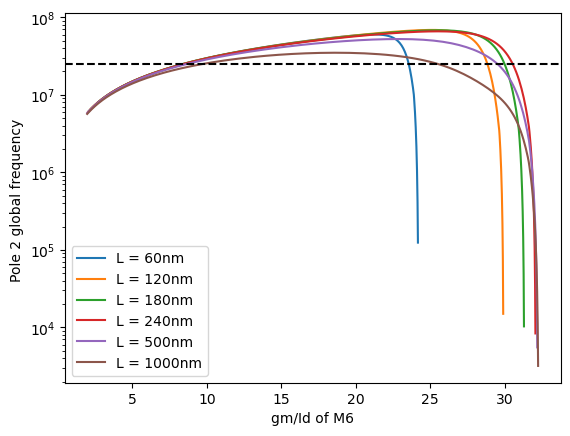

In [155]:
pole_2_global = {}
plt.figure()
for L in L_values:
    pole_2_global[L] = ((C_13 * pmos[L]['gm']) / ( 2*np.pi * out_cgd_worst_case * ((pmos[L]['cgs'] + pmos[L]['cgd'] + M_3['cgd'] + M_3['cdd'] + M_5['cgd'] + M_5['cdd']) + C_13)))
    plt.plot(pmos[L]['gmoverid'], pole_2_global[L], label=f'L = {L}nm')
plt.axhline(y=2.5*10*10**6, color='k', linestyle='--')
plt.yscale('log')
plt.xlabel('gm/Id of M6')
plt.ylabel('Pole 2 global frequency ')
plt.legend()
plt.show()

In [156]:
M_6_L = 120
M_6_gmoverid_desired = 25
M_6_index = (np.abs(pmos[M_6_L]['gmoverid'] - M_6_gmoverid_desired)).idxmin()
M_6 = pmos[M_6_L].iloc[M_6_index]

print(((C_13 * M_6['gm']) / ( 2*np.pi * out_cgd_worst_case * ((M_6['cgs'] + M_6['cgd'] + M_3['cgd'] + M_3['cdd'] + M_5['cgd'] + M_5['cdd']) + C_13))) * 10**-6, end='')
print(' MHz')

68.70546746768834 MHz


### M_7

In [157]:
M_7_L = M_5_L
M_7_gmoverid_desired = M_5['gmoverid']
M_7_index = (np.abs(pmos[M_7_L]['gmoverid'] - M_7_gmoverid_desired)).idxmin()
M_7 = pmos[M_7_L].iloc[M_7_index]

### Final sizing

In [166]:
print('Final sizing for current-mirrors stage:')
print(f'M6:  L = {M_6_L:>4} nm  |  w = {M_6["w"]*10**6:>7.3f} um  |  id = {M_6["id"]:<6.2e} A  |  gds = {M_6["gds"]*10**6:>7.2f} uS  |  gm = {M_6["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_6["gmoverid"]:>7.2f}  |  vdsat = {M_6["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_6["vgs"]*10**3:>7.2f} mV   |  cdd = {M_6["cdd"]*10**15:>7.2f} fF  |  cgd = {M_6["cgd"]*10**15:>7.2f} fF  |  cgs = {M_6["cgs"]*10**15:>7.2f} fF  |  csb = {M_6["csb"]*10**15:>7.2f} fF')
print(f'M7:  L = {M_7_L:>4} nm  |  w = {M_7["w"]*10**6:>7.3f} um  |  id = {M_7["id"]:<6.2e} A  |  gds = {M_7["gds"]*10**6:>7.2f} uS  |  gm = {M_7["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_7["gmoverid"]:>7.2f}  |  vdsat = {M_7["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_7["vgs"]*10**3:>7.2f} mV   |  cdd = {M_7["cdd"]*10**15:>7.2f} fF  |  cgd = {M_7["cgd"]*10**15:>7.2f} fF  |  cgs = {M_7["cgs"]*10**15:>7.2f} fF  |  csb = {M_7["csb"]*10**15:>7.2f} fF')
print(f'M8:  L = {M_8_L:>4} nm  |  w = {M_8["w"]*10**6:>7.3f} um  |  id = {M_8["id"]:<6.2e} A  |  gds = {M_8["gds"]*10**6:>7.2f} uS  |  gm = {M_8["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_8["gmoverid"]:>7.2f}  |  vdsat = {M_8["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_8["vgs"]*10**3:>7.2f} mV   |  cdd = {M_8["cdd"]*10**15:>7.2f} fF  |  cgd = {M_8["cgd"]*10**15:>7.2f} fF  |  cgs = {M_8["cgs"]*10**15:>7.2f} fF  |  csb = {M_8["csb"]*10**15:>7.2f} fF')
print(f'M9:  L = {M_9_L:>4} nm  |  w = {M_9["w"]*10**6:>7.3f} um  |  id = {M_9["id"]:<6.2e} A  |  gds = {M_9["gds"]*10**6:>7.2f} uS  |  gm = {M_9["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_9["gmoverid"]:>7.2f}  |  vdsat = {M_9["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_9["vgs"]*10**3:>7.2f} mV   |  cdd = {M_9["cdd"]*10**15:>7.2f} fF  |  cgd = {M_9["cgd"]*10**15:>7.2f} fF  |  cgs = {M_9["cgs"]*10**15:>7.2f} fF  |  csb = {M_9["csb"]*10**15:>7.2f} fF')
print(f'M10:  L = {M_10_L:>4} nm  |  w = {M_10["w"]*10**6:>7.3f} um  |  id = {M_10["id"]:<6.2e} A  |  gds = {M_10["gds"]*10**6:>7.2f} uS  |  gm = {M_10["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_10["gmoverid"]:>7.2f}  |  vdsat = {M_10["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_10["vgs"]*10**3:>7.2f} mV   |  cdd = {M_10["cdd"]*10**15:>7.2f} fF  |  cgd = {M_10["cgd"]*10**15:>7.2f} fF  |  cgs = {M_10["cgs"]*10**15:>7.2f} fF  |  csb = {M_10["csb"]*10**15:>7.2f} fF')
print(f'M11:  L = {M_11_L:>4} nm  |  w = {M_11["w"]*10**6:>7.3f} um  |  id = {M_11["id"]:<6.2e} A  |  gds = {M_11["gds"]*10**6:>7.2f} uS  |  gm = {M_11["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_11["gmoverid"]:>7.2f}  |  vdsat = {M_11["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_11["vgs"]*10**3:>7.2f} mV   |  cdd = {M_11["cdd"]*10**15:>7.2f} fF  |  cgd = {M_11["cgd"]*10**15:>7.2f} fF  |  cgs = {M_11["cgs"]*10**15:>7.2f} fF  |  csb = {M_11["csb"]*10**15:>7.2f} fF')
print(f'M12:  L = {M_12_L:>4} nm  |  w = {M_12["w"]*10**6:>7.3f} um  |  id = {M_12["id"]:<6.2e} A  |  gds = {M_12["gds"]*10**6:>7.2f} uS  |  gm = {M_12["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_12["gmoverid"]:>7.2f}  |  vdsat = {M_12["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_12["vgs"]*10**3:>7.2f} mV   |  cdd = {M_12["cdd"]*10**15:>7.2f} fF  |  cgd = {M_12["cgd"]*10**15:>7.2f} fF  |  cgs = {M_12["cgs"]*10**15:>7.2f} fF  |  csb = {M_12["csb"]*10**15:>7.2f} fF')
print(f'M13:  L = {M_13_L:>4} nm  |  w = {M_13["w"]*10**6:>7.3f} um  |  id = {M_13["id"]:<6.2e} A  |  gds = {M_13["gds"]*10**6:>7.2f} uS  |  gm = {M_13["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_13["gmoverid"]:>7.2f}  |  vdsat = {M_13["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_13["vgs"]*10**3:>7.2f} mV   |  cdd = {M_13["cdd"]*10**15:>7.2f} fF  |  cgd = {M_13["cgd"]*10**15:>7.2f} fF  |  cgs = {M_13["cgs"]*10**15:>7.2f} fF  |  csb = {M_13["csb"]*10**15:>7.2f} fF')
print(f'M14:  L = {M_14_L:>4} nm  |  w = {M_14["w"]*10**6:>7.3f} um  |  id = {M_14["id"]:<6.2e} A  |  gds = {M_14["gds"]*10**6:>7.2f} uS  |  gm = {M_14["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_14["gmoverid"]:>7.2f}  |  vdsat = {M_14["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_14["vgs"]*10**3:>7.2f} mV   |  cdd = {M_14["cdd"]*10**15:>7.2f} fF  |  cgd = {M_14["cgd"]*10**15:>7.2f} fF  |  cgs = {M_14["cgs"]*10**15:>7.2f} fF  |  csb = {M_14["csb"]*10**15:>7.2f} fF')
print(f'MNB:  L = {M_NB_L:>4} nm  |  w = {M_NB["w"]*10**6:>7.3f} um  |  id = {M_NB["id"]:<6.2e} A  |  gds = {M_NB["gds"]*10**6:>7.2f} uS  |  gm = {M_NB["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_NB["gmoverid"]:>7.2f}  |  vdsat = {M_NB["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_NB["vgs"]*10**3:>7.2f} mV   |  cdd = {M_NB["cdd"]*10**15:>7.2f} fF  |  cgd = {M_NB["cgd"]*10**15:>7.2f} fF  |  cgs = {M_NB["cgs"]*10**15:>7.2f} fF  |  csb = {M_NB["csb"]*10**15:>7.2f} fF')
print(f'MPB:  L = {M_PB_L:>4} nm  |  w = {M_PB["w"]*10**6:>7.3f} um  |  id = {M_PB["id"]:<6.2e} A  |  gds = {M_PB["gds"]*10**6:>7.2f} uS  |  gm = {M_PB["gm"]*10**6:>7.2f} uS  |  gmoverid = {M_PB["gmoverid"]:>7.2f}  |  vdsat = {M_PB["vdsat"]*10**3:>7.2f} mV  |  vgs = {M_PB["vgs"]*10**3:>7.2f} mV   |  cdd = {M_PB["cdd"]*10**15:>7.2f} fF  |  cgd = {M_PB["cgd"]*10**15:>7.2f} fF  |  cgs = {M_PB["cgs"]*10**15:>7.2f} fF  |  csb = {M_PB["csb"]*10**15:>7.2f} fF')


Final sizing for current-mirrors stage:
M6:  L =  120 nm  |  w = 132.429 um  |  id = 2.78e-05 A  |  gds =   30.74 uS  |  gm =  692.19 uS  |  gmoverid =   24.92  |  vdsat =   50.87 mV  |  vgs =  400.00 mV   |  cdd =   30.28 fF  |  cgd =   29.96 fF  |  cgs =   54.18 fF  |  csb =    3.82 fF
M7:  L =  240 nm  |  w = 127.194 um  |  id = 2.78e-05 A  |  gds =   21.63 uS  |  gm =  691.46 uS  |  gmoverid =   24.89  |  vdsat =   55.97 mV  |  vgs =  400.00 mV   |  cdd =   29.46 fF  |  cgd =   29.09 fF  |  cgs =  103.68 fF  |  csb =   11.19 fF
M8:  L = 1000 nm  |  w =   6.718 um  |  id = 2.78e-05 A  |  gds =   12.95 uS  |  gm =  278.47 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    6.69 fF  |  cgd =    3.06 fF  |  cgs =   59.84 fF  |  csb =    8.55 fF
M9:  L = 1000 nm  |  w =   6.718 um  |  id = 2.78e-05 A  |  gds =   12.95 uS  |  gm =  278.47 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    6.69 fF  |  cgd =    3.06 fF  |  cg

## Bias circuit

In [159]:
nmos = copy.deepcopy(nmos_data)
pmos = copy.deepcopy(pmos_data)

### Vb_0

In [160]:
# Vb_0 = Vdd - Vsg_0 = Vdd - (vdsat_0 + vth_0)
Vb_0 = Vdd - M_0['vdsat'] - M_0['vth']
print(f'Vb_0 = {Vb_0:.2f} V')

BIAS_M_4_L = M_0_L
BIAS_M_4 = M_0.copy()

BIAS_M_5_L = M_0_L
BIAS_M_5 = M_0.copy()

Vb_0 = 0.64 V


### Vb_1

In [161]:
# Vb_1 = Vgs_2 = vdsat_2 + vth_2
Vb_1 = M_2['vdsat'] + M_2['vth']
print(f'Vb_1 = {Vb_1:.2f} V')

BIAS_M_0_L = M_2_L
BIAS_M_0 = M_2.copy()

BIAS_M_1_L = M_2_L
BIAS_M_1 = M_2.copy()

BIAS_M_3_L = M_2_L
BIAS_M_3 = M_2.copy()

Vb_1 = 0.61 V


### Vb_2

In [162]:
# Vb_2 = vdsat_3 + vth_3 + vdsat_2 + Vb_2_tol

# Vb_2_tol = 0.2
# Vb_2 = M_3['vdsat'] + M_3['vth'] + M_2['vdsat'] + Vb_2_tol
# print(f'Vb_2 = {Vb_2:.2f} V')

BIAS_M_6_vdsat_tol = 50 * 10**-3
BIAS_M_6_vdsat_desired =  M_3['vdsat'] + M_2['vdsat'] + BIAS_M_6_vdsat_tol
print(f'Vdsat_6 = {BIAS_M_6_vdsat_desired:.2f} V')

BIAS_M_6_w = M_3_L

Vdsat_6 = 0.25 V


### Vb_3

In [163]:
# Vb_3 = Vdd - vdsat_4 - vdsat_5 - vth_5

# Vb_3_tol = 0.2
# Vb_3 = Vdd - M_4['vdsat'] - M_5['vdsat'] - M_5['vth'] + Vb_3_tol
# print(f'Vb_3 = {Vb_3:.2f} V')

BIAS_M_2_vdsat_tol = 50 * 10**-3
BIAS_M_2_vdsat_desired =  M_4['vdsat'] + M_5['vdsat'] + BIAS_M_2_vdsat_tol
print(f'Vdsat_2 = {BIAS_M_2_vdsat_desired:.2f} V')

BIAS_M_2_w = M_5_L

Vdsat_2 = 0.24 V


In [164]:
print('Final sizing for bias circuit:')
print(f'M_0:  L = {BIAS_M_0_L:>4} nm  |  w = {BIAS_M_0["w"]*10**6:>7.3f} um  |  id = {BIAS_M_0["id"]:<6.2e} A  |  gds = {BIAS_M_0["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_0["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_0["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_0["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_0["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_0["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_0["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_0["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_0["csb"]*10**15:>7.2f} fF')
print(f'M_1:  L = {BIAS_M_1_L:>4} nm  |  w = {BIAS_M_1["w"]*10**6:>7.3f} um  |  id = {BIAS_M_1["id"]:<6.2e} A  |  gds = {BIAS_M_1["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_1["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_1["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_1["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_1["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_1["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_1["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_1["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_1["csb"]*10**15:>7.2f} fF')
#print(f'M_2:  L = {BIAS_M_2_L:>4} nm  |  w = {BIAS_M_2["w"]*10**6:>7.3f} um  |  id = {BIAS_M_2["id"]:<6.2e} A  |  gds = {BIAS_M_2["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_2["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_2["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_2["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_2["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_2["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_2["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_2["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_2["csb"]*10**15:>7.2f} fF')
print(f'M_3:  L = {BIAS_M_3_L:>4} nm  |  w = {BIAS_M_3["w"]*10**6:>7.3f} um  |  id = {BIAS_M_3["id"]:<6.2e} A  |  gds = {BIAS_M_3["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_3["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_3["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_3["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_3["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_3["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_3["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_3["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_3["csb"]*10**15:>7.2f} fF')
print(f'M_4:  L = {BIAS_M_4_L:>4} nm  |  w = {BIAS_M_4["w"]*10**6:>7.3f} um  |  id = {BIAS_M_4["id"]:<6.2e} A  |  gds = {BIAS_M_4["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_4["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_4["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_4["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_4["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_4["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_4["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_4["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_4["csb"]*10**15:>7.2f} fF')
print(f'M_5:  L = {BIAS_M_5_L:>4} nm  |  w = {BIAS_M_5["w"]*10**6:>7.3f} um  |  id = {BIAS_M_5["id"]:<6.2e} A  |  gds = {BIAS_M_5["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_5["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_5["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_5["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_5["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_5["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_5["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_5["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_5["csb"]*10**15:>7.2f} fF')
#print(f'M_6:  L = {BIAS_M_6_L:>4} nm  |  w = {BIAS_M_0["w"]*10**6:>7.3f} um  |  id = {BIAS_M_0["id"]:<6.2e} A  |  gds = {BIAS_M_0["gds"]*10**6:>7.2f} uS  |  gm = {BIAS_M_0["gm"]*10**6:>7.2f} uS  |  gmoverid = {BIAS_M_0["gmoverid"]:>7.2f}  |  vdsat = {BIAS_M_0["vdsat"]*10**3:>7.2f} mV  |  vgs = {BIAS_M_0["vgs"]*10**3:>7.2f} mV   |  cdd = {BIAS_M_0["cdd"]*10**15:>7.2f} fF  |  cgd = {BIAS_M_0["cgd"]*10**15:>7.2f} fF  |  cgs = {BIAS_M_0["cgs"]*10**15:>7.2f} fF  |  csb = {BIAS_M_0["csb"]*10**15:>7.2f} fF')

Final sizing for bias circuit:
M_0:  L = 1000 nm  |  w =   1.710 um  |  id = 7.07e-06 A  |  gds =    3.29 uS  |  gm =   70.86 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    1.70 fF  |  cgd =    0.78 fF  |  cgs =   15.23 fF  |  csb =    2.18 fF
M_1:  L = 1000 nm  |  w =   1.710 um  |  id = 7.07e-06 A  |  gds =    3.29 uS  |  gm =   70.86 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    1.70 fF  |  cgd =    0.78 fF  |  cgs =   15.23 fF  |  csb =    2.18 fF
M_3:  L = 1000 nm  |  w =   1.710 um  |  id = 7.07e-06 A  |  gds =    3.29 uS  |  gm =   70.86 uS  |  gmoverid =   10.02  |  vdsat =  148.50 mV  |  vgs =  600.00 mV   |  cdd =    1.70 fF  |  cgd =    0.78 fF  |  cgs =   15.23 fF  |  csb =    2.18 fF
M_4:  L = 1000 nm  |  w =   5.011 um  |  id = 7.07e-06 A  |  gds =    6.98 uS  |  gm =   71.17 uS  |  gmoverid =   10.07  |  vdsat =  136.09 mV  |  vgs =  570.00 mV   |  cdd =    2.71 fF  |  cgd =    1.69 fF  |  cgs =  